In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
import SimpleNeuralNetwork as SimpNN
from matplotlib import pyplot as plt
from pubchempy import *

In [2]:
# Load the dataset. Clean it up by removing missing molecule features. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature
molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

xe = torch.tensor(np.array(eutectic_compilation.xe).astype(float) / 100.0)
eutectic_compilation.xe = xe

In [3]:
# Mix of Absolute Z-score and Min-Max normalization on selective molecule features
# weight = torch.tensor(np.array(molecule_features.molecular_weight).astype(float))
# complexity = torch.tensor(np.array(molecule_features.complexity).astype(float))
# # rotbond = torch.tensor(np.array(molecule_features.rotatable_bond_count).astype(float))
# heavyatom = torch.tensor(np.array(molecule_features.heavy_atom_count).astype(float))
# toparea = torch.tensor(np.array(molecule_features.topological_area).astype(float))

# molecule_features.molecular_weight = torch.min(weight) + ((weight - torch.min(weight)) * (torch.max(weight) - torch.min(weight)) / (torch.max(weight) - torch.min(weight)))
# molecule_features.complexity = torch.min(complexity) + ((complexity - torch.min(complexity)) * (torch.max(complexity) - torch.min(complexity)) / (torch.max(complexity) - torch.min(complexity)))
# # molecule_features.rotatable_bond_count = torch.abs((rotbond - torch.mean(rotbond)) / (torch.std(rotbond) + 1e-9))
# molecule_features.heavy_atom_count = torch.min(heavyatom) + ((heavyatom - torch.min(heavyatom)) * (torch.max(heavyatom) - torch.min(heavyatom)) / (torch.max(heavyatom) - torch.min(heavyatom)))
# molecule_features.topological_area = torch.abs((toparea - torch.mean(toparea)) / (torch.std(toparea) + 1e-9))

In [4]:
# Min-Max normalization of Te
Te = torch.tensor(np.array(eutectic_compilation.Te).astype(float))
eutectic_compilation.Te = (Te - min(Te)) / (max(Te) - min(Te))
# eutectic_compilation.Te = (Te - torch.mean(Te)) / (torch.std(Te) + 1e-8)

In [5]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [6]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [7]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,0.766,0.000000
1,BF3,SO2,0.952,0.003312
2,BCl3,GeCl4,0.760,0.007752
3,BCl3,PCl3,0.940,0.009866
4,BCl3,PCl3,0.200,0.013742
...,...,...,...,...
4463,Sc2O3,ZrO2,0.522,0.911910
4464,UO2,ZrO2,0.475,0.947146
4465,UO2,ZrO2,0.500,0.947146
4466,UN,W,1.000,1.000000


In [8]:
train_ec

,molA,molB,xe,Te
1444,CsI,TlCl,0.610,0.187104
1946,Rb2TeO3,TeO2,0.890,0.224806
3433,PbO,PbSe,0.800,0.316420
2767,BaCl2,NaCl,0.400,0.276956
1562,CsCl,PbCl2,0.100,0.197322
...,...,...,...,...
4150,GeO2,SrO,0.430,0.534884
1215,BeF2,KF,0.580,0.163848
1178,AgCl,KBr,0.750,0.161381
549,SnCl2,TlCl,0.820,0.113813


In [9]:
val_ec

,molA,molB,xe,Te
1124,KBF3OH,KBF4,0.915,0.156801
687,AgCl,TlCl,0.550,0.122622
1824,K2SO4,MoO3,0.400,0.217759
1557,CdCl2,CsBr,0.428,0.196617
3092,BaF2,NaCl,0.280,0.294574
...,...,...,...,...
3063,KCl,MoCl3,0.900,0.292812
4038,BaO,GeO2,0.392,0.437984
1103,CsCl,HfCl4,0.349,0.155039
2389,K2TaF7,NaCl,0.300,0.254757


In [10]:
test_ec

,molA,molB,xe,Te
6,TiCl4,VOCl3,0.290,0.015152
14,BBr3,SiCl4,0.264,0.020437
19,POCl3,SiCl4,0.040,0.023326
28,GeCl4,SnCl4,0.910,0.030550
63,ICl,TeCl4,0.800,0.052149
...,...,...,...,...
4349,Al2O3,UO2,0.740,0.718111
4359,Al2O3,Sm2O3,0.318,0.726920
4440,Sc2O3,ThO2,0.830,0.830867
4444,Cr2O3,MgO,0.600,0.836152


In [11]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [12]:
# Using the PubChemPy API to see how to extract molecule features. Get the features of a bunch of random molecules by CID.
import random

props = ['MolecularWeight', 'Complexity', 'RotatableBondCount', 'HeavyAtomCount', 'MolecularFormula', 'tpsa']
cids = []
for i in range(10):
    cids.append(random.randint(1, 1000))
    
molprops = get_properties(props, cids, 'cid', as_dataframe=True)
molprops

,MolecularFormula,MolecularWeight,TPSA,Complexity,RotatableBondCount,HeavyAtomCount
CID,,,,,,
24,C9H17N5O8,323.26,216.0,491,3,22
85,C7H16NO3+,162.21,57.5,139,4,11
389,C5H12N2O2,132.16,89.3,95,4,9
965,C18H34O2,282.5,37.3,234,15,20
903,C12H14N2O2,218.25,65.1,257,3,16
155,C5H6N4O3,170.13,121.0,207,2,12
213,C20H32O5,352.5,76.0,459,12,25
86,C7H7NO3,153.14,83.6,160,1,11
345,C7H8O6,188.13,112.0,287,4,13


In [13]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [14]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 30
max_epochs = 30
lrbase = 1e-6
lrmax = 1e-5

# For xe
overfit_bound = 0.3
# For Te
# overfit_bound = 0.3

train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MAE is basically standard deviation, so the baseline is the std of the dataset
# MAE tells us how much + or - pred is from truth on average
train_stdev = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))
# train_stdev = torch.std(torch.tensor(np.array(train_ec["Te"]).astype(float)))

train_param = "xe"

In [15]:
importlib.reload(MR)
importlib.reload(SNN)
importlib.reload(SimpNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrbase, lrmax, 
                    train_dset, val_dset, test_dset, train_stdev, train_param)

In [16]:
trloss, trbase, vloss, vbase = modelrunner.train_and_validate(overfit_bound)
outputs, invouts, truths = modelrunner.test()

Epoch 1 | Train Loss: 0.222954 | Train Baseline: 0.501771 | Val Loss: 0.218459 | Val Baseline: 0.489711
Early Stop. Validation loss under overfitting threshold.
Test Loss: 0.219 | Test Baseline: 0.527



In [17]:
simptrloss, simptrbase, simpvloss, simpvbase = modelrunner.simp_train_and_validate(overfit_bound)
simpoutputs, simpinvouts, simptruths = modelrunner.simp_test()

Epoch 1 | Train Loss: 0.500296 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Epoch 2 | Train Loss: 0.500091 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Callback to epoch 1 | Patience 1/5
Epoch 3 | Train Loss: 0.500339 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Callback to epoch 1 | Patience 2/5
Epoch 4 | Train Loss: 0.499804 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Callback to epoch 1 | Patience 3/5
Epoch 5 | Train Loss: 0.500098 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Callback to epoch 1 | Patience 4/5
Epoch 6 | Train Loss: 0.499942 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Callback to epoch 1 | Patience 5/5
Epoch 7 | Train Loss: 0.499994 | Train Baseline: 0.501771 | Val Loss: 0.507736 | Val Baseline: 0.489711
Early Stop. Validation loss stopped decreasing.
Test Loss: 0.471 | Test Baseline: 0.527



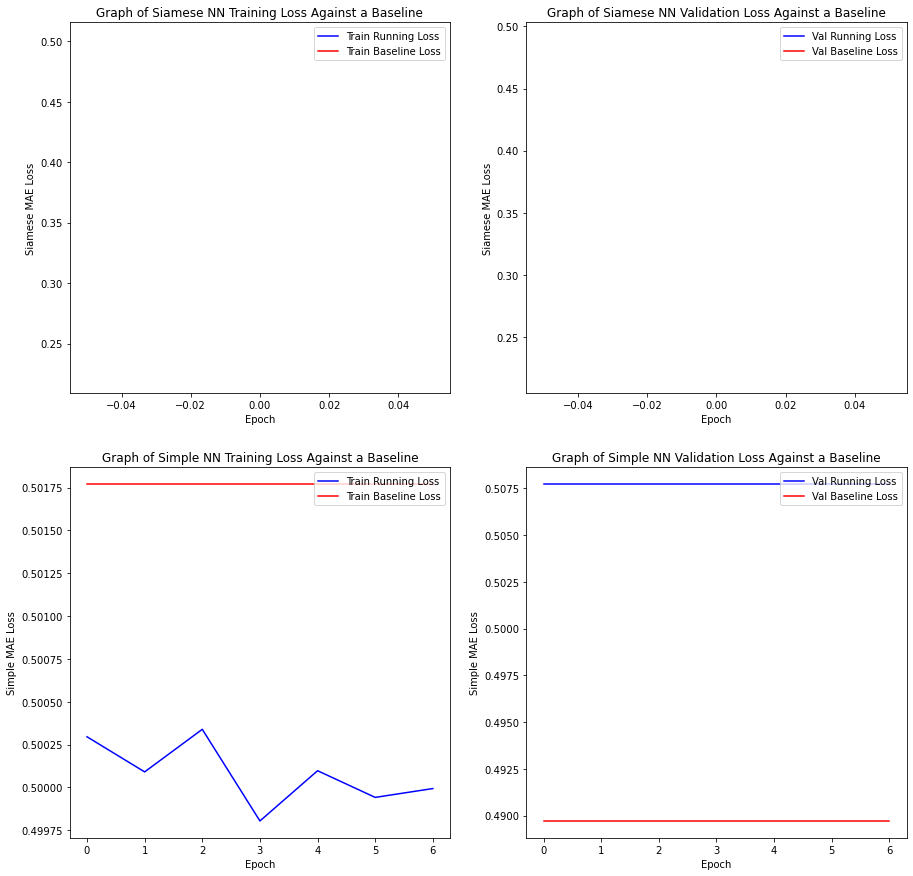

In [18]:
l1 = len(trloss)
l2 = len(simptrloss)
x1 = np.arange(l1)
x2 = np.arange(l2)

fig, axes = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
            
axes[0, 0].plot(x1, trloss[0:l1], label="Train Running Loss", c="blue")
axes[0, 0].plot(x1, trbase[0:l1], label="Train Baseline Loss", c="red")
axes[0, 0].set_title("Graph of Siamese NN Training Loss Against a Baseline")
axes[0, 0].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(x1, vloss[0:l1], label="Val Running Loss", c="blue")
axes[0, 1].plot(x1, vbase[0:l1], label="Val Baseline Loss", c="red")
axes[0, 1].set_title("Graph of Siamese NN Validation Loss Against a Baseline")
axes[0, 1].set(xlabel="Epoch", ylabel="Siamese MAE Loss")
axes[0, 1].legend(loc="upper right")

axes[1, 0].plot(x2, simptrloss[0:l2], label="Train Running Loss", c="blue")
axes[1, 0].plot(x2, simptrbase[0:l2], label="Train Baseline Loss", c="red")
axes[1, 0].set_title("Graph of Simple NN Training Loss Against a Baseline")
axes[1, 0].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 0].legend(loc="upper right")

axes[1, 1].plot(x2, simpvloss[0:l2], label="Val Running Loss", c="blue")
axes[1, 1].plot(x2, simpvbase[0:l2], label="Val Baseline Loss", c="red")
axes[1, 1].set_title("Graph of Simple NN Validation Loss Against a Baseline")
axes[1, 1].set(xlabel="Epoch", ylabel="Simple MAE Loss")
axes[1, 1].legend(loc="upper right")

plt.show()

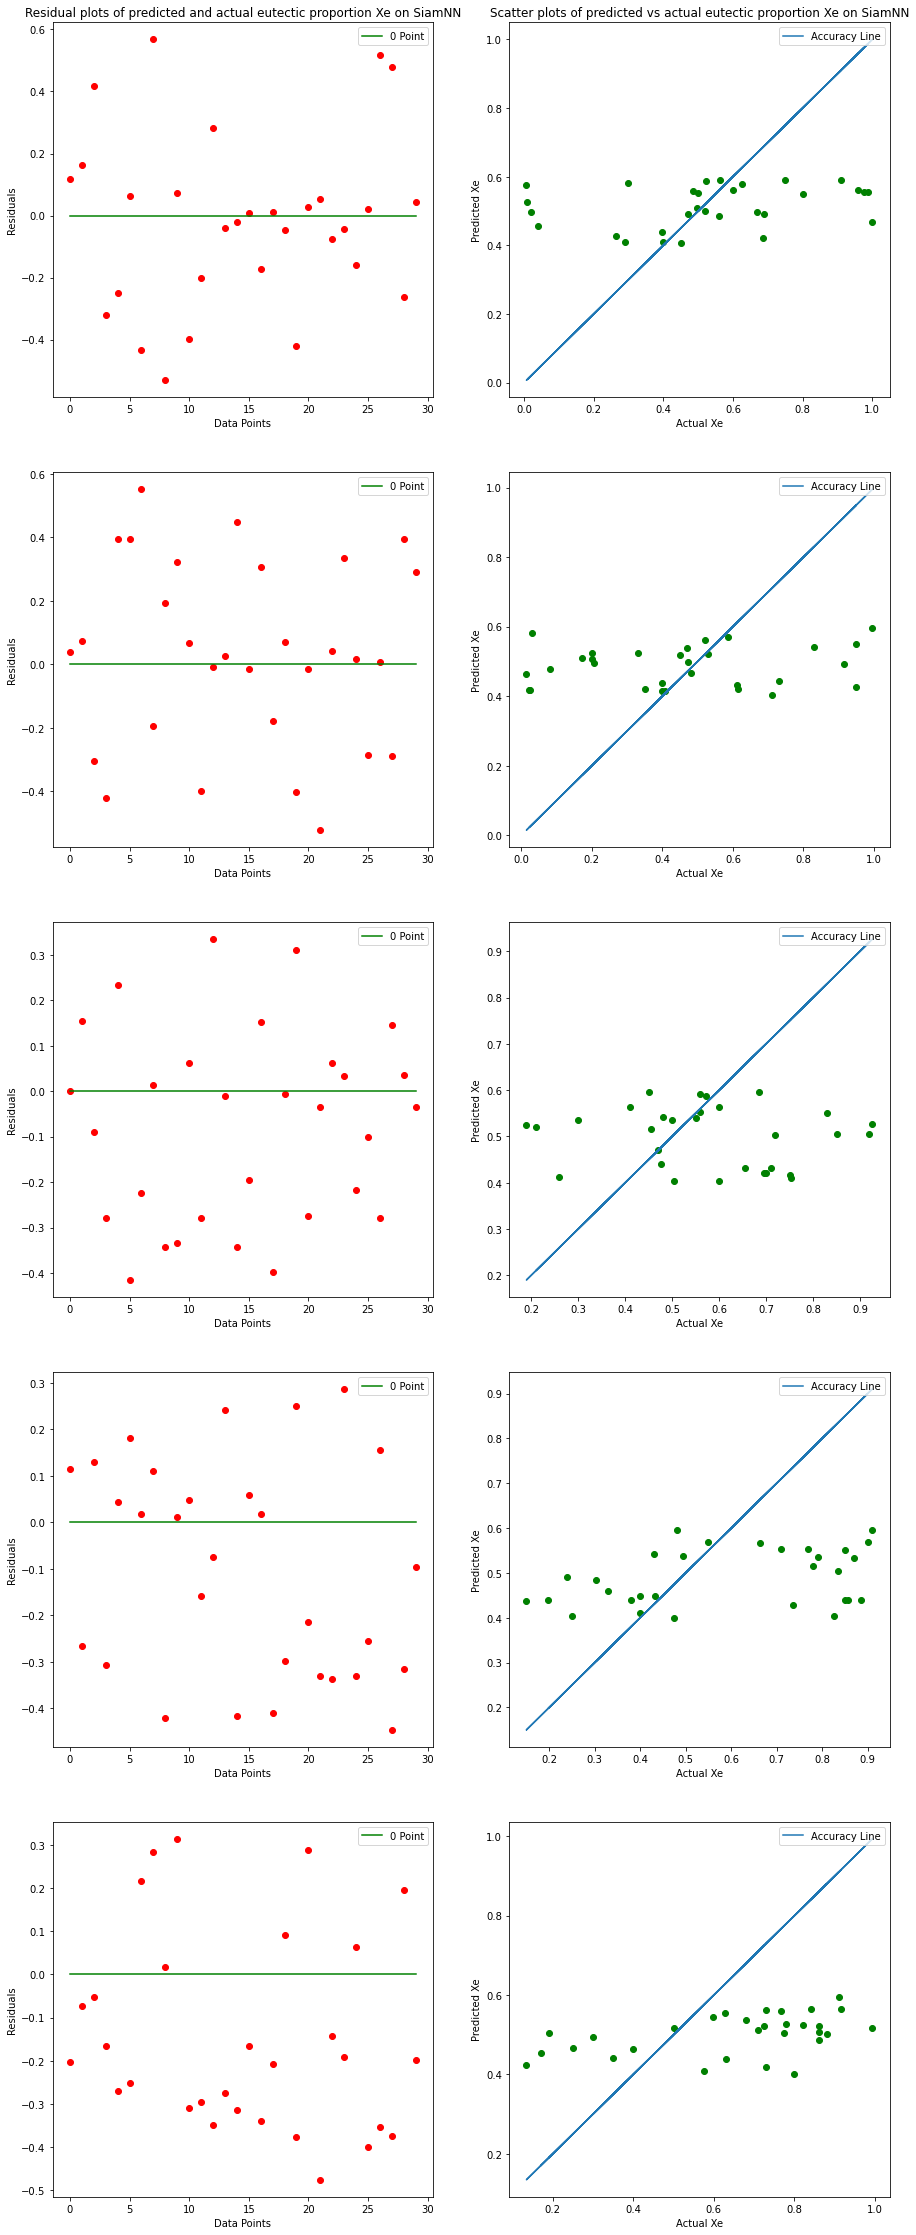

In [19]:
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(15)

l = batchsize
pred = 0
succ = 1
x = np.arange(l)
        
for row in range(5):
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(truths[pred*l:succ*l], outputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(truths[pred*l:succ*l], truths[pred*l:succ*l], label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
            
    pred += 1
    succ += 1

if train_param == "xe":
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe on SiamNN")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe on SiamNN")
else: 
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic temperature Te on SiamNN")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic temperature Te on SiamNN")

plt.show()

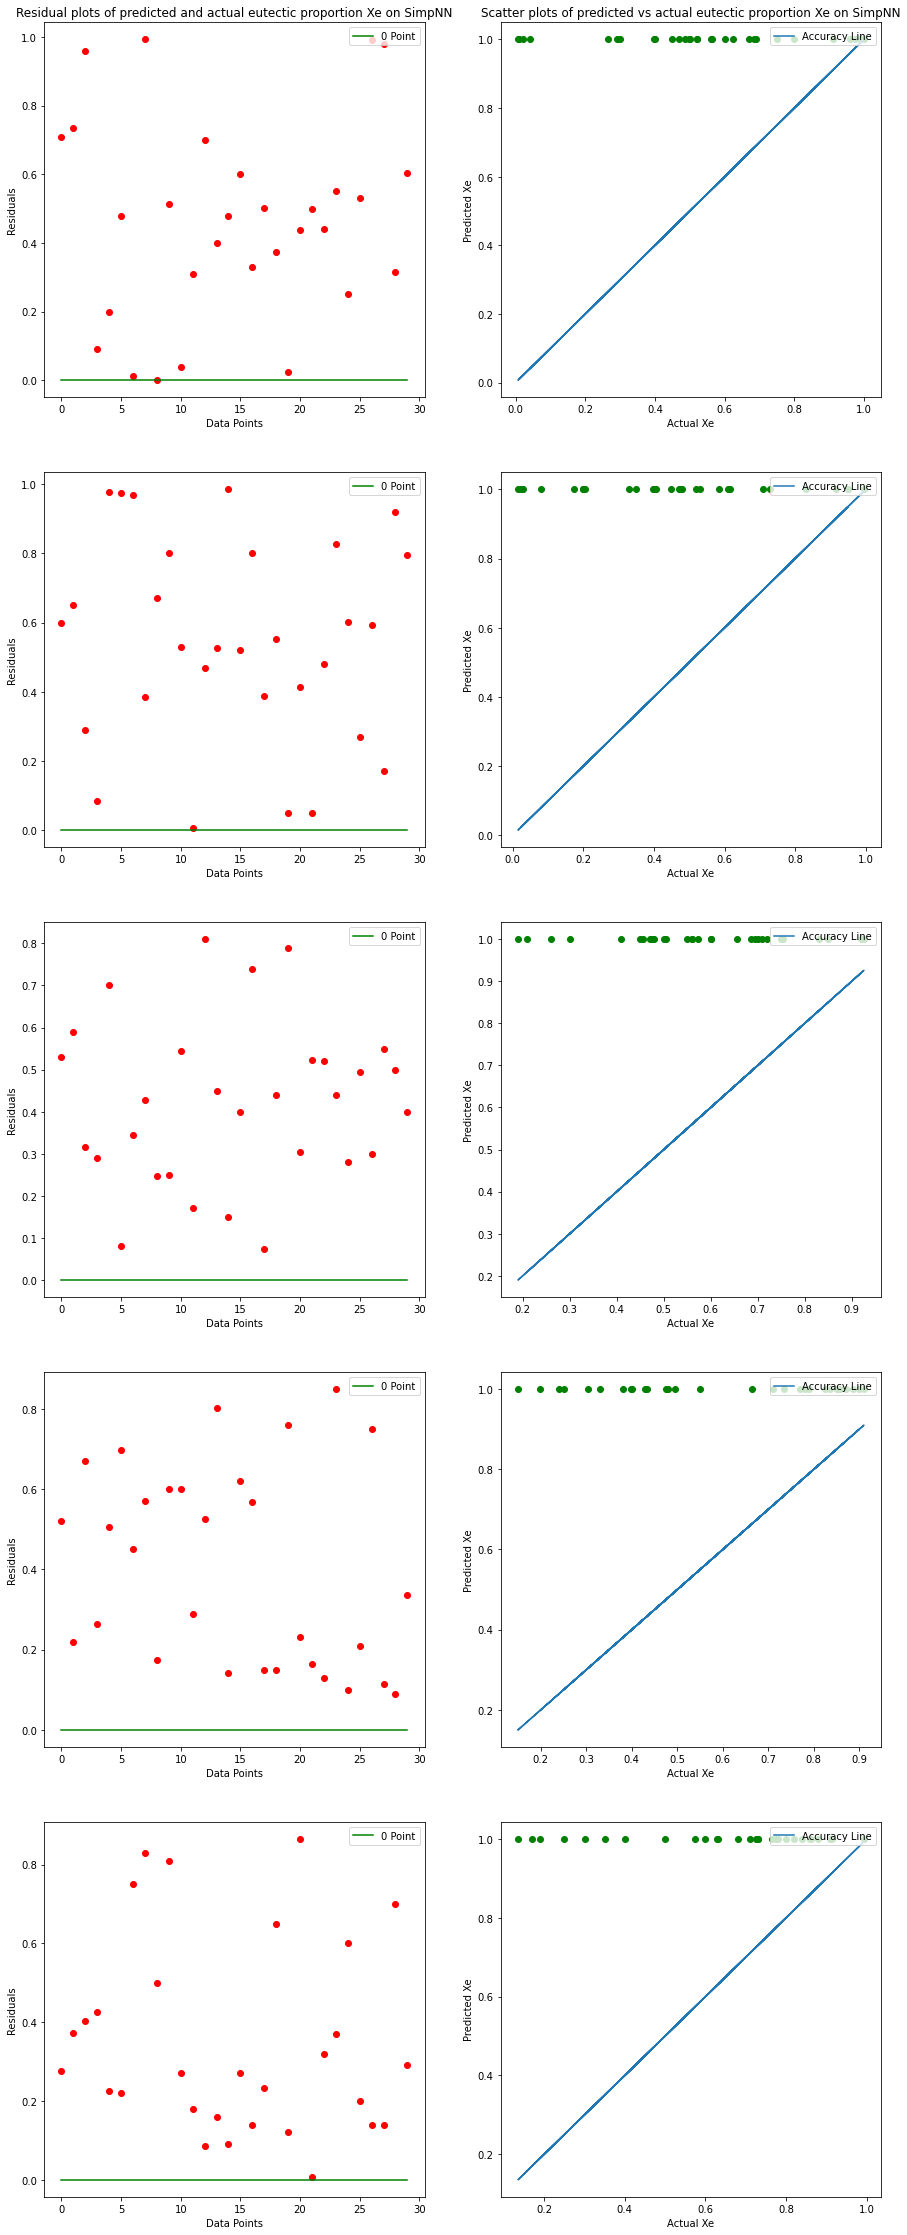

In [20]:
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(15)

l = batchsize
pred = 0
succ = 1
x = np.arange(l)
        
for row in range(5):
    axes[row, 0].scatter(x, simpoutputs[pred*l:succ*l] - simptruths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(simptruths[pred*l:succ*l], simpoutputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(simptruths[pred*l:succ*l], simptruths[pred*l:succ*l], label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")
            
    pred += 1
    succ += 1

if train_param == "xe":
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe on SimpNN")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe on SimpNN")
else:
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic temperature Te on SimpNN")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic temperature Te on SimpNN")

plt.show()

In [21]:
# Print the values from the last batch processed just for the user to see
if train_param == "xe":
    disp = pd.DataFrame({
        'f(A,B) + f(B,A)': outputs + invouts,
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3),
        'Simple Pred': np.round(simpoutputs, 3)
    })
else:
    disp = pd.DataFrame({
        'Truth': np.round(truths, 3),
        'Siamese Pred': np.round(outputs, 3), 
        'Simple Pred': np.round(simpoutputs, 3)
    })
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B) + f(B,A)",Truth,Siamese Pred,Simple Pred
0,1.000000,0.290000,0.409000,1.000000
1,1.000000,0.264000,0.427000,1.000000
2,1.000000,0.040000,0.457000,1.000000
3,1.000000,0.910000,0.590000,1.000000
4,1.000000,0.800000,0.550000,1.000000
5,1.000000,0.522000,0.586000,1.000000
6,1.000000,0.988000,0.554000,1.000000
7,1.000000,0.007000,0.575000,1.000000
8,1.000000,1.000000,0.469000,1.000000
9,1.000000,0.486000,0.560000,1.000000


In [22]:
# fig.savefig('D:\\Research\\UConn_ML\\Plots\\plots_7_25_22.png')